In [1]:
import tensorflow as tf
import numpy as np

# import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.models import Sequential
from keras.models import Model
from keras.layers import (
    Input,
    Dense,
    Dropout,
    BatchNormalization,
    Conv1D,
    Flatten,
    concatenate,
    GlobalAveragePooling1D,
    MaxPooling1D,
)
from keras.optimizers import SGD, Adam

# import mean_absolute_percentage_error
from keras.losses import mean_absolute_percentage_error

from IPython import display

from src.models import (
    plot_metrics,
    plot_test_performance
)

2023-06-13 12:36:09.463385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset

Load full dataset

In [2]:
input_file = "normalized_data.feather"

df = pd.read_feather(input_file)
total_rows = len(df)


print(f"Length of the dataset in {input_file}: {total_rows}")

Length of the dataset in normalized_data.feather: 51840


In [3]:
# Transform Signal column in a good type and shape
df["Signal"] = df["Signal"].apply(lambda x: [float(value) for value in x.split(" ")])
df.head()

,Drug1,Drug2,Conc1,Conc2,ScanRate,Capacitance,Signal,Sensitivity1,Sensitivity2,Peak_pos1,Peak_pos2,Peak_width1,Peak_width2,k_m1,k_m2,v_max1,v_max2
0,0,1,0.028169,0.028169,0.01,1.0,"[0.006850648514866037, 33.39623902311649, 66.7...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
1,0,1,0.028169,0.028169,0.10,1.0,"[0.006850648514866037, 3.3461764536005996, 6.6...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
2,0,1,0.028169,0.028169,1.00,1.0,"[0.006850648514866037, 0.34117019664901005, 0....",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
3,0,1,0.028169,0.070423,0.01,1.0,"[0.006858229126972536, 33.396248401363984, 66....",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499
4,0,1,0.028169,0.070423,0.10,1.0,"[0.006858229126972536, 3.3461858318480897, 6.6...",0.069231,0.043956,-0.657778,-1.0,1.0,0.375,1.0,0.001157,0.006706,0.003499


# Correlation Analysis (Spearman)

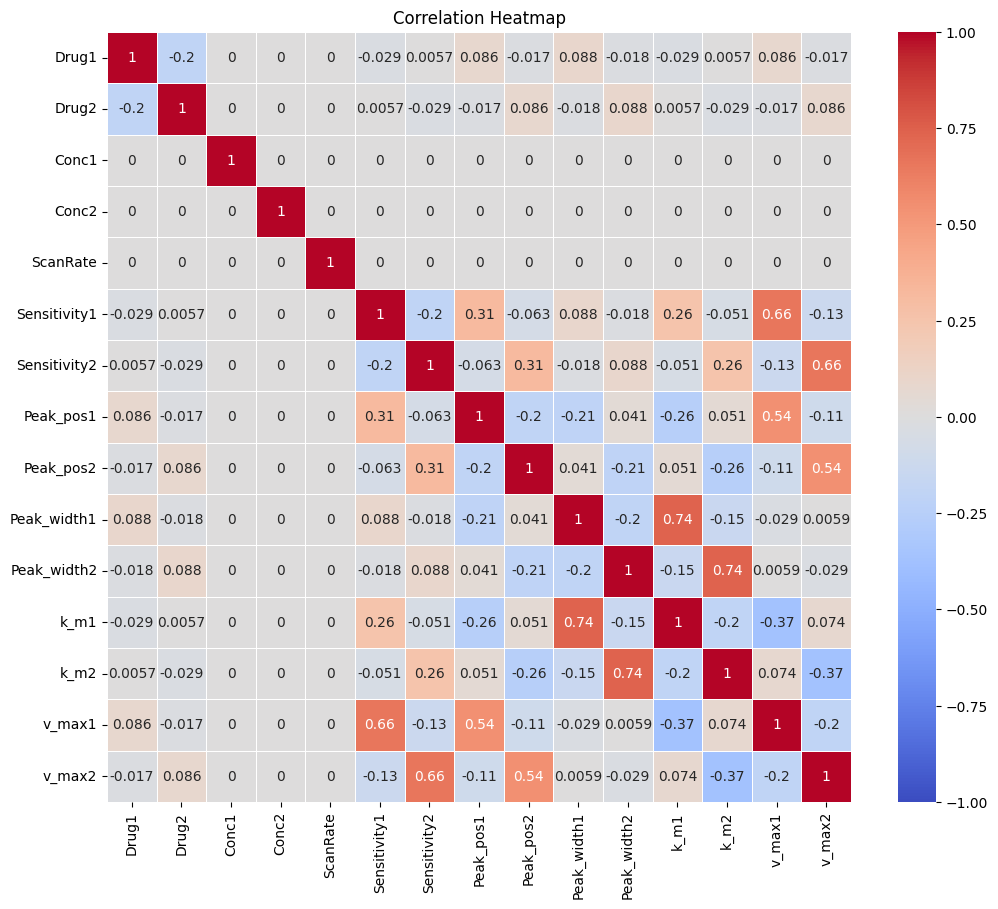

In [4]:
df_sample = df
# Remove the "Signal" column
data_no_signal = df_sample.drop(["Signal", "Capacitance"], axis=1)

# Compute the correlation matrix
corr_matrix = data_no_signal.corr(method="spearman")

# Generate the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Drop automatically features with coeff > 0.7

Columns to drop: {'k_m1', 'v_max2', 'v_max1', 'k_m2'}


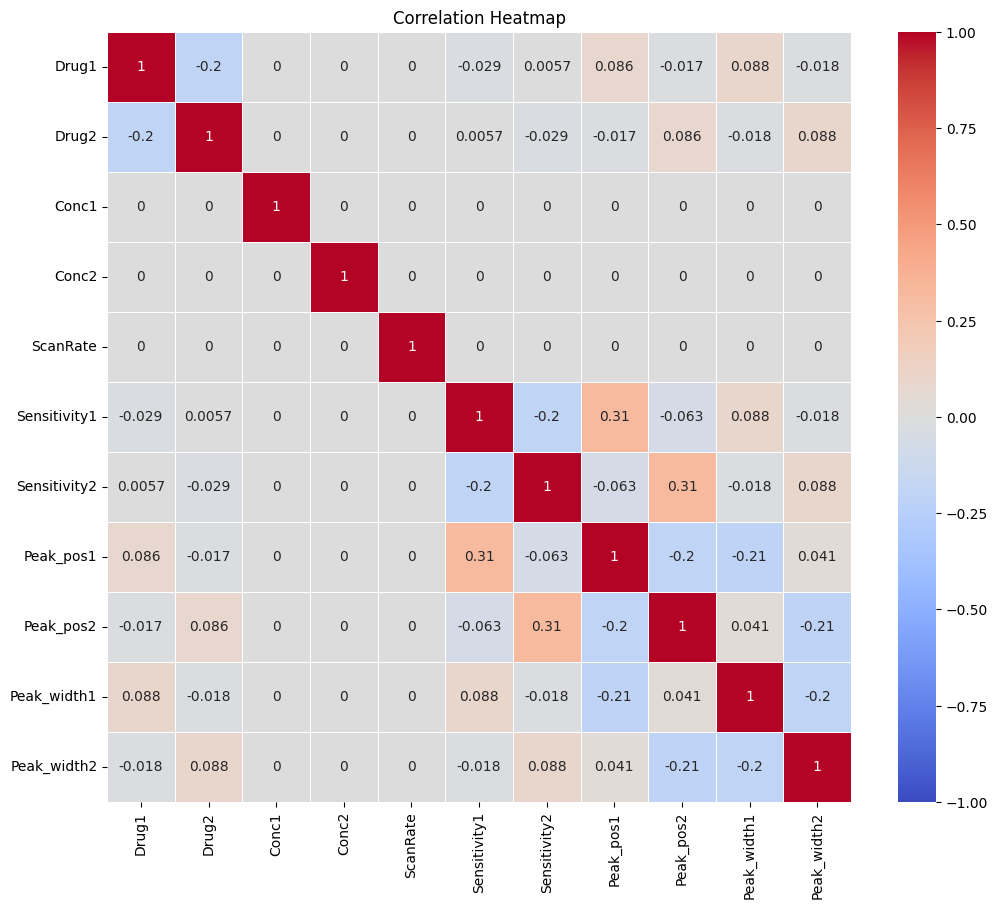

In [5]:
# drop the columns with correlation > 0.7

# Set the threshold
threshold = 0.6

# copy df_sample features names
df_features = data_no_signal.copy()
corr_matrix = df_features.corr(method="spearman")

# Iterate over the columns in reverse order
for col in reversed(corr_matrix.columns):
    # Find the indices of the columns with correlations greater than the threshold
    correlated_indices = np.where(abs(corr_matrix[col]) > threshold)[0]

    # If there are correlated columns other than the current column itself
    if len(correlated_indices) > 1:
        # Get the column names to drop
        columns_to_drop = corr_matrix.columns[correlated_indices][1]

        # Drop the correlated columns
        df_features.drop(columns=columns_to_drop, inplace=True)

        # Recalculate the correlation matrix
        corr_matrix = df_features.corr(method="spearman")

# print the droped columns
print(f"Columns to drop: {set(data_no_signal.columns) - set(df_features.columns)}")
features_to_drop = set(data_no_signal.columns) - set(df_features.columns)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Transform features in numpy array

In [6]:
processed_features = []
# build a list of all features in df_sample without the features to drop
features = [feature for feature in df_sample.columns if feature not in features_to_drop]
print(f"Features to use: {features}")
print(f"Features dropped: {features_to_drop}")

for feature in features:
    # if feature is different from "Conc1" and "Conc2" and "Signal"
    if feature != "Conc1" and feature != "Conc2" and feature != "Signal":
        process_feature = np.array(df_sample[feature])
        processed_features.append(process_feature)
    if feature == "Signal":
        Signal = np.array(df_sample["Signal"]).tolist()
        Signal_normalized = np.array(
            [signal / np.max(np.abs(signal)) for signal in Signal]
        )

X_other = np.column_stack(
    processed_features
)  # Equivalent to X_other = np.column_stack((Drug1, Drug2, Scan_Rate, Capacitance, Sensitivity1, Sensitivity2, Peak_pos1, Peak_pos2, Peak_width1, Peak_width2, v_max1, v_max2))

# Create target variables (Conc1 and Conc2)
Conc1 = np.array(df_sample["Conc1"])
Conc2 = np.array(df_sample["Conc2"])
Y = np.column_stack((Conc1, Conc2))

Features to use: ['Drug1', 'Drug2', 'Conc1', 'Conc2', 'ScanRate', 'Capacitance', 'Signal', 'Sensitivity1', 'Sensitivity2', 'Peak_pos1', 'Peak_pos2', 'Peak_width1', 'Peak_width2']
Features dropped: {'k_m1', 'v_max2', 'v_max1', 'k_m2'}


In [7]:

# SPlit data into train and test sets
(
    X_train_other,
    X_test_other,
    Signal_train,
    Signal_test,
    y_train,
    y_test,
) = train_test_split(
    X_other, Signal_normalized, Y, test_size=0.1, random_state=42, shuffle=True
)

# Create and train the model

In [10]:
def simple_model_Adam_best(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(96, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="relu")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error']) # To keep
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def simple_model_Adam_trial_1(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(192, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(96, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(12, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dense(3, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="relu")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def improved_model_Adam_trial_2(
    n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95
):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization
    x = Dense(256, kernel_initializer="he_normal")(combined)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(64, kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2)(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = Adam(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


def simple_model_SGD(n_features, initial_lr=0.001, decay_steps=300, decay_rate=0.95):
    # Flatten the signal input for use in an MLP
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)

    # Other features input branch (Dense)
    input_other = Input(shape=(n_features,))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers with batch normalization and he_normal initialization

    x = Dense(96, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(48, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
    x = Dense(24, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    output = Dense(2, activation="linear")(x)

    # Create an ExponentialDecay learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr, decay_steps=decay_steps, decay_rate=decay_rate
    )
    # Use the learning rate schedule with the Adam optimizer
    optimizer = SGD(learning_rate=lr_schedule)

    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model

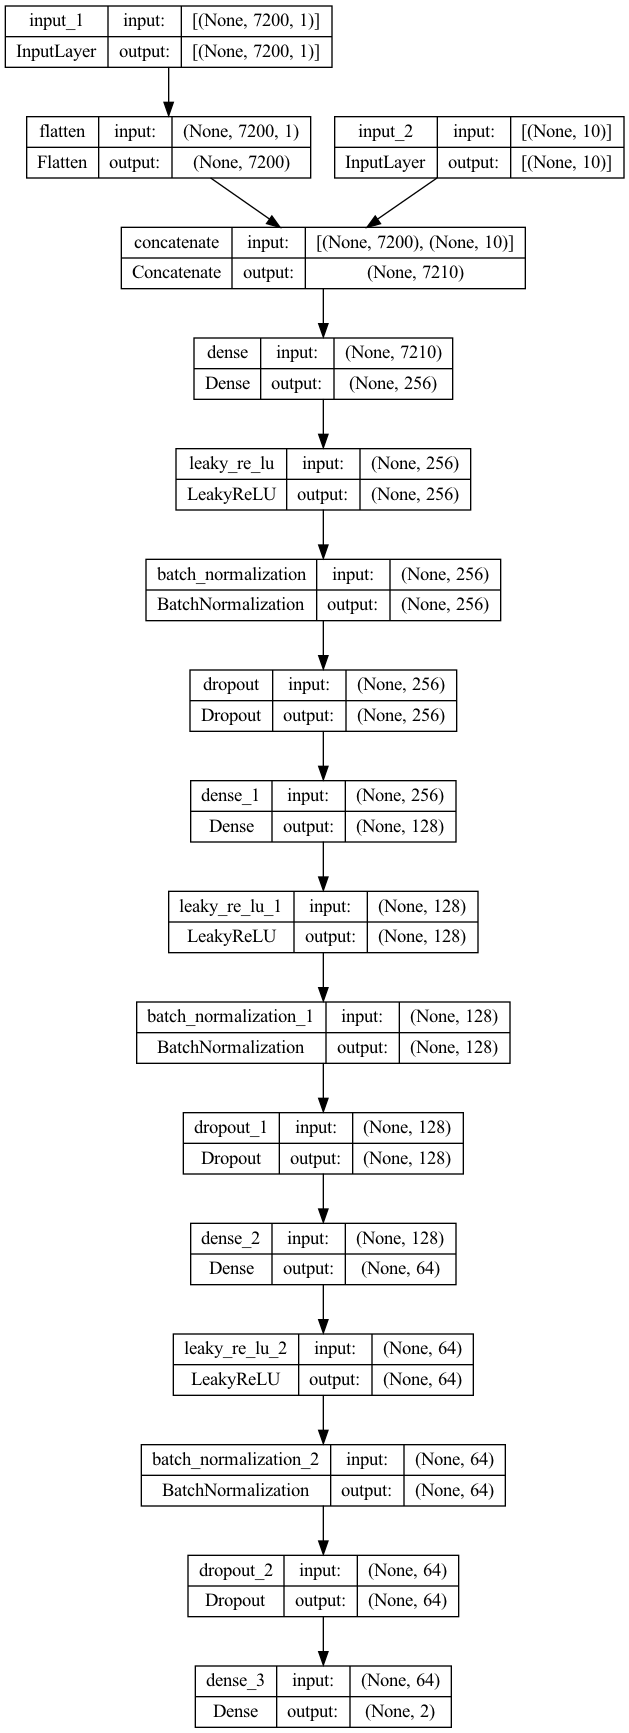

In [11]:
model = improved_model_Adam_trial_2(
    X_other.shape[1], initial_lr=0.001, decay_steps=9000, decay_rate=0.95
)

# draw the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/100
292/292 [==============================] - 9s 25ms/step - loss: 0.7800 - mean_absolute_percentage_error: 289.0664 - val_loss: 0.0940 - val_mean_absolute_percentage_error: 140.0822
Epoch 2/100
292/292 [==============================] - 4s 14ms/step - loss: 0.2788 - mean_absolute_percentage_error: 202.0389 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 150.4109
Epoch 3/100
292/292 [==============================] - 4s 14ms/step - loss: 0.1631 - mean_absolute_percentage_error: 167.9664 - val_loss: 0.0801 - val_mean_absolute_percentage_error: 148.3016
Epoch 4/100
292/292 [==============================] - 4s 15ms/step - loss: 0.1149 - mean_absolute_percentage_error: 154.9762 - val_loss: 0.0802 - val_mean_absolute_percentage_error: 148.2066
Epoch 5/100
292/292 [==============================] - 5s 15ms/step - loss: 0.0955 - mean_absolute_percentage_error: 151.2989 - val_loss: 0.0800 - val_mean_absolute_percentage_error: 145.7413
Epoch 6/100
292/292 [===================

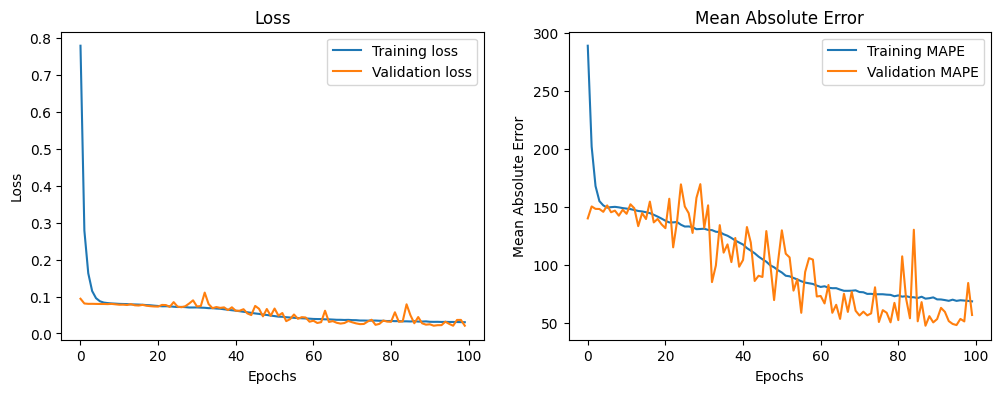

162/162 [==============================] - 1s 3ms/step - loss: 0.0218 - mean_absolute_percentage_error: 59.3380
Test Loss: 0.02179708518087864, Test Mean Absolute Error: 59.337955474853516
162/162 [==============================] - 1s 3ms/step


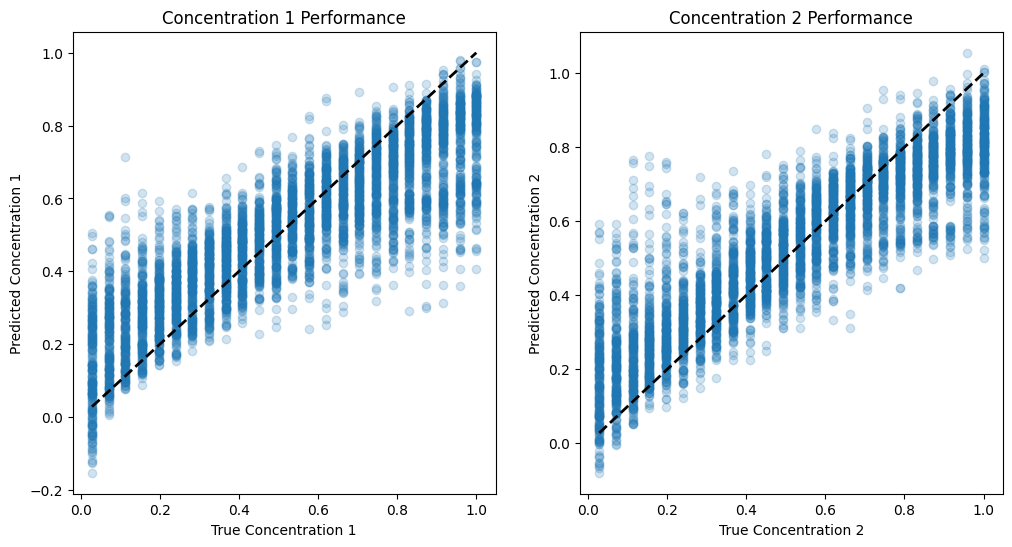

In [25]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 3ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 58.45671195285043%
Standard Deviation of Percentage Error on concentration 1: 139.7913687379549%
Mean Percentage Error on concentration 2: 60.21919325239004%
Standard Deviation of Percentage Error on concentration 2: 160.14884451344872%


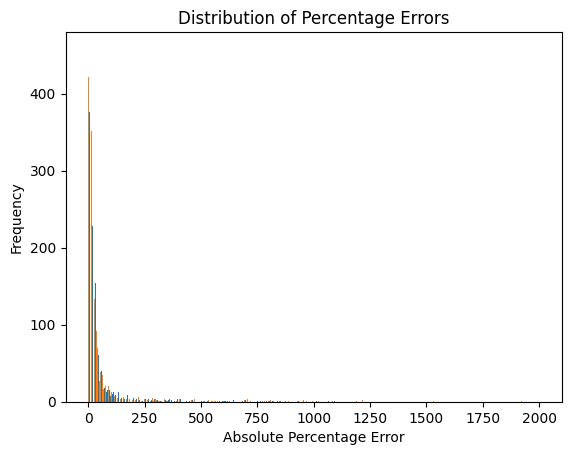

In [26]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins="auto")
    # zoom on the first 30% of the data
    # plt.xlim(0, 500)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.show()


# Use the function on your model and test set
# replace "your_model" with the variable of your model
evaluate_model(model, Signal_test, X_test_other, y_test)

In [45]:
import keras_tuner as kt
import os
import datetime
from keras.callbacks import TensorBoard

# Define the log directory for TensorBoard logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [46]:
def model_builder(hp):
    # Hyperparameters
    hp_initial_lr = hp.Float(
        "initial_lr", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
    )
    hp_decay_steps = hp.Int(
        "decay_steps", min_value=100, max_value=1000, step=100, default=300
    )
    hp_decay_rate = hp.Float(
        "decay_rate", min_value=0.8, max_value=0.96, step=0.04, default=0.95
    )
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32, default=96)
    hp_dropout = hp.Float("dropout", min_value=0, max_value=0.4, step=0.1, default=0.1)

    # Inputs
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)
    input_other = Input(shape=(X_other.shape[1],))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers
    x = Dense(hp_units, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp_dropout)(x)
    x = Dense(hp_units // 2, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dense(hp_units // 4, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(2 * hp_dropout)(x)

    # Output
    output = Dense(2, activation="relu")(x)

    # Learning rate schedule and optimizer
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp_initial_lr,
        decay_steps=hp_decay_steps,
        decay_rate=hp_decay_rate,
    )
    optimizer = Adam(learning_rate=lr_schedule)

    # Model and compilation
    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model


# Use the TensorBoard callback for logging
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Initialize tuner.
tuner = kt.RandomSearch(
    model_builder,
    objective="val_mean_absolute_error",
    max_trials=5,  # Number of different models to try
    executions_per_trial=3,  # Number of times to fit a model per trial to reduce noise
    directory=".",  # Directory to store the results, set to current directory
    project_name="Drugs_sim",  # Project name
)

# Run the hyperparameter search.
tuner.search(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    validation_data=([Signal_test, X_test_other], y_test),
    batch_size=64,
    callbacks=[tensorboard_callback],
)  # Add the callback here

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('initial_lr')}. The optimal decay steps is {best_hps.get('decay_steps')}
and the optimal decay rate is {best_hps.get('decay_rate')}.
"""
)

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    [Signal_train, X_train_other], y_train, epochs=100, validation_split=0.2, verbose=1
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

# Use the function on your model and test set
evaluate_model(model, Signal_test, X_test_other, y_test)

In [12]:
import keras_tuner as kt
from tensorflow import keras
from keras import layers
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters as hp


import os
import datetime
from keras.callbacks import TensorBoard

# Define the log directory for TensorBoard logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
def model_builder_old(hp):
    # Hyperparameters
    hp_initial_lr = hp.Float(
        "initial_lr", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
    )
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32, default=96)
    hp_dropout = hp.Float("dropout", min_value=0, max_value=0.4, step=0.1, default=0.1)

    # Inputs
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)
    input_other = Input(shape=(X_other.shape[1],))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers
    x = Dense(hp_units, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp_dropout)(x)
    x = Dense(hp_units // 2, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dense(hp_units // 4, activation="relu", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dropout(2 * hp_dropout)(x)

    # Output
    output = Dense(2, activation="relu")(x)

    # Learning rate and optimizer
    optimizer = Adam(learning_rate=hp_initial_lr)

    # Model and compilation
    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model

TypeError: HyperParameters.Choice() missing 1 required positional argument: 'name'

In [19]:
def model_builder(hp):
    # Hyperparameters
    hp_initial_lr = hp.Float(
        "initial_lr", min_value=1e-4, max_value=1e-2, sampling="LOG", default=1e-3
    )
    hp_units = hp.Int("units", min_value=32, max_value=512, step=32, default=96)
    hp_dropout = hp.Float("dropout", min_value=0, max_value=0.4, step=0.1, default=0.1)
    hp_num_layers = hp.Choice("num_layers", values=[2, 3])
    # hp_batch_size = hp.Choice('batch_size', values = [32, 64, 128, 256])

    # Inputs
    input_signal = Input(shape=(7200, 1))
    flat_signal = Flatten()(input_signal)
    input_other = Input(shape=(X_other.shape[1],))

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers
    x = Dense(hp_units, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp_dropout)(x)

    for i in range(hp_num_layers - 1):
        x = Dense(
            hp_units // (2 ** (i + 1)),
            activation="relu",
            kernel_initializer="he_normal",
        )(x)
        x = BatchNormalization()(x)
        if i < hp_num_layers - 2:  # Apply dropout to all layers except the last one
            x = Dropout(hp_dropout)(x)

    # Output
    output = Dense(2, activation="relu")(x)

    # Learning rate and optimizer
    optimizer = Adam(learning_rate=hp_initial_lr)

    # Model and compilation
    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer, loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model  # , hp_batch_size


# Initialize tuner.
tuner = RandomSearch(
    model_builder,
    # objective="val_mean_absolute_error",
    objective="mean_absolute_percentage_error",
    max_trials=5,  # Number of different models to try
    executions_per_trial=3,  # Number of times to fit a model per trial to reduce noise
    directory=".",  # Directory to store the results, set to current directory
    project_name="Drugs_sim",  # Project name
)

# Use the TensorBoard callback for logging
log_dir = "./logs"  # Please change this directory as per your requirements
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Run the hyperparameter search.
tuner.search(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    validation_data=([Signal_test, X_test_other], y_test),
    callbacks=[tensorboard_callback],
)  # Add the callback here

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 37m 38s]
val_mean_absolute_error: 0.07769164939721425

Best val_mean_absolute_error So Far: 0.04896878326932589
Total elapsed time: 08h 42m 24s
INFO:tensorflow:Oracle triggered exit


KeyError: 'batch_size does not exist.'


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352, the optimal learning rate for the optimizer
is 0.00020812318085000362, and the optimal dropout rate is 0.0. The optimal number of layers is 3.

Training with batch size 16
Epoch 1/100
2333/2333 [==============================] - 24s 10ms/step - loss: 0.1382 - mean_absolute_error: 0.2975 - val_loss: 0.0964 - val_mean_absolute_error: 0.2584
Epoch 2/100
2333/2333 [==============================] - 20s 9ms/step - loss: 0.0807 - mean_absolute_error: 0.2368 - val_loss: 0.0878 - val_mean_absolute_error: 0.2440
Epoch 3/100
2333/2333 [==============================] - 19s 8ms/step - loss: 0.0785 - mean_absolute_error: 0.2339 - val_loss: 0.0805 - val_mean_absolute_error: 0.2360
Epoch 4/100
2333/2333 [==============================] - 18s 8ms/step - loss: 0.0762 - mean_absolute_error: 0.2300 - val_loss: 0.0789 - val_mean_absolute_error: 0.2312
Epoch 5/100
2333/2333 [===================

KeyError: 'mean_absolute_percentage_error'

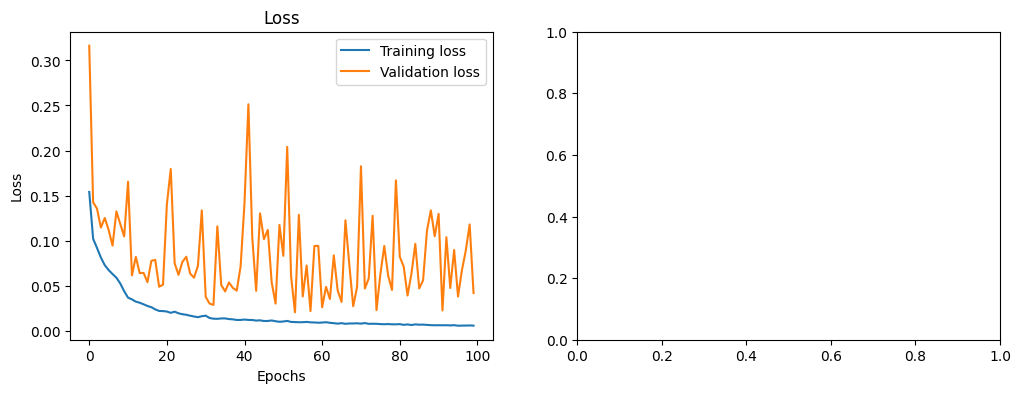

In [20]:
print(
    f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, the optimal learning rate for the optimizer
is {best_hps.get('initial_lr')}, and the optimal dropout rate is {best_hps.get('dropout')}. The optimal number of layers is {best_hps.get('num_layers')}.
"""
)

best_batch_size = 32
min_val_loss = float("inf")

# Manually adjust batch size and train
for batch_size in [16, 32, 64, 128, 256]:
    print(f"Training with batch size {batch_size}")
    model = tuner.hypermodel.build(best_hps)  # Build a new model for each batch size
    history = model.fit(
        [Signal_train, X_train_other],
        y_train,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
    )

    current_val_loss = min(history.history["val_loss"])

    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        best_batch_size = batch_size

print(f"The best batch size is {best_batch_size}")

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

# Use the function on your model and test set
evaluate_model(model, Signal_test, X_test_other, y_test)

# BEST MODEL

In [11]:
def create_model(
    input_shape_signal, input_shape_other, units, dropout_rate, initial_lr, num_layers
):
    # Define the inputs
    input_signal = Input(shape=input_shape_signal)
    flat_signal = Flatten()(input_signal)
    input_other = Input(shape=input_shape_other)

    # Combine inputs
    combined = concatenate([flat_signal, input_other])

    # Dense layers
    x = Dense(units, activation="relu", kernel_initializer="he_normal")(combined)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    for i in range(num_layers - 1):
        x = Dense(
            units // (2 ** (i + 1)), activation="relu", kernel_initializer="he_normal"
        )(x)
        x = BatchNormalization()(x)
        if i < num_layers - 2:  # Apply dropout to all layers except the last one
            x = Dropout(dropout_rate)(x)

    # Output
    output = Dense(2, activation="relu")(x)

    # Learning rate and optimizer
    optimizer = Adam(learning_rate=initial_lr)

    # Model and compilation
    model = Model(inputs=[input_signal, input_other], outputs=output)
    model.compile(
        optimizer=optimizer,
        loss="mean_squared_error",
        metrics=["mean_absolute_percentage_error"],
    )

    return model


# Define your hyperparameters
input_shape_signal = (7200, 1)
input_shape_other = (X_train_other.shape[1],)
units = 352
dropout_rate = 0.0
initial_lr = 0.00020812318085000362
num_layers = 3

# Create the model
model = create_model(
    input_shape_signal, input_shape_other, units, dropout_rate, initial_lr, num_layers
)

# Print a summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7200, 1)]    0           []                               
                                                                                                  
 flatten (Flatten)              (None, 7200)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7210)         0           ['flatten[0][0]',                
                                                                  'input_2[0][0]']            

Epoch 1/50
2333/2333 [==============================] - 19s 8ms/step - loss: 0.1318 - mean_absolute_percentage_error: 142.9037 - val_loss: 0.0813 - val_mean_absolute_percentage_error: 141.3860
Epoch 2/50
2333/2333 [==============================] - 19s 8ms/step - loss: 0.0808 - mean_absolute_percentage_error: 143.5557 - val_loss: 0.0849 - val_mean_absolute_percentage_error: 153.2826
Epoch 3/50
2333/2333 [==============================] - 20s 8ms/step - loss: 0.0773 - mean_absolute_percentage_error: 140.6191 - val_loss: 0.0831 - val_mean_absolute_percentage_error: 151.9182
Epoch 4/50
2333/2333 [==============================] - 20s 8ms/step - loss: 0.0753 - mean_absolute_percentage_error: 138.4573 - val_loss: 0.0803 - val_mean_absolute_percentage_error: 119.2116
Epoch 5/50
2333/2333 [==============================] - 24s 10ms/step - loss: 0.0724 - mean_absolute_percentage_error: 134.5174 - val_loss: 0.1137 - val_mean_absolute_percentage_error: 92.1918
Epoch 6/50
2333/2333 [=============

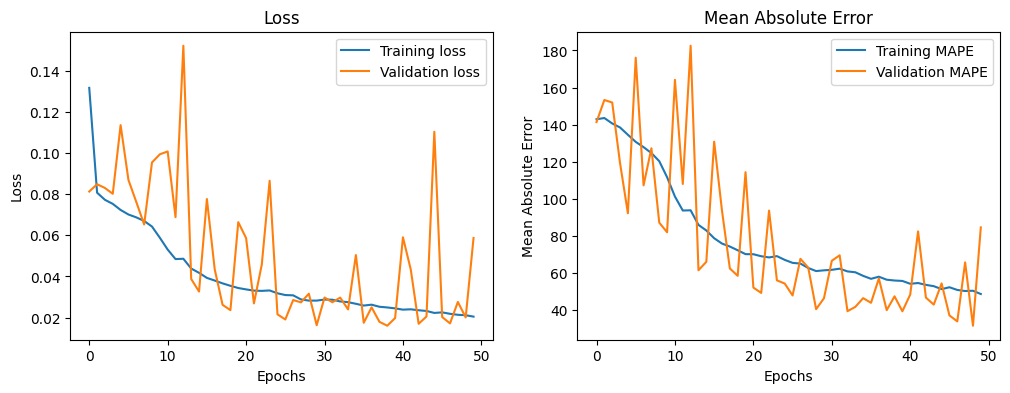

162/162 [==============================] - 1s 4ms/step - loss: 0.0587 - mean_absolute_percentage_error: 85.7380
Test Loss: 0.05870494619011879, Test Mean Absolute Error: 85.73802185058594
162/162 [==============================] - 1s 3ms/step


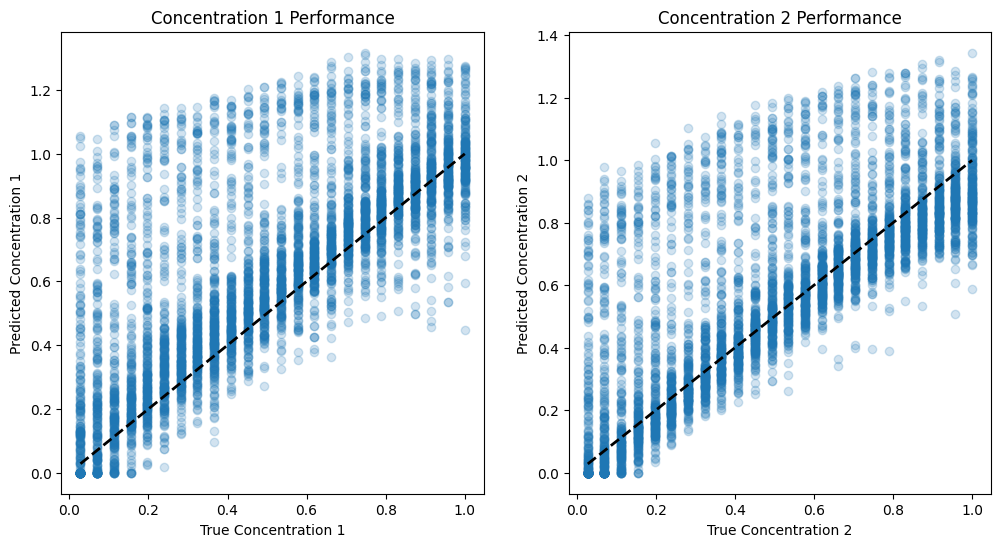

In [12]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 3ms/step - loss: 0.0587 - mean_absolute_percentage_error: 85.7380
Test Loss: 0.05870494619011879, Test Mean Absolute Error: 85.73802185058594
162/162 [==============================] - 1s 3ms/step


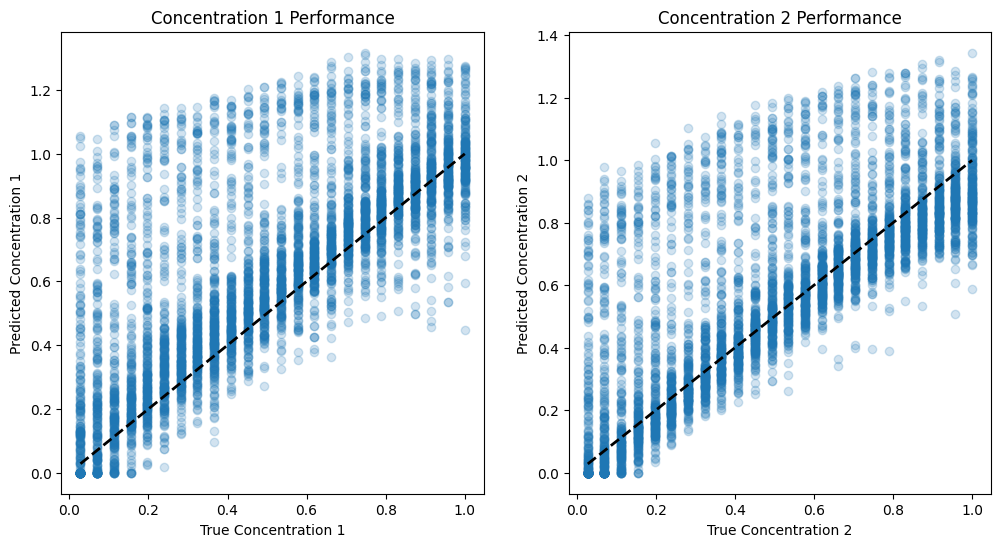

In [13]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 3ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 96.08893667682308%
Standard Deviation of Percentage Error on concentration 1: 296.29196854486565%
Mean Percentage Error on concentration 2: 75.38709809372256%
Standard Deviation of Percentage Error on concentration 2: 241.18922526330078%


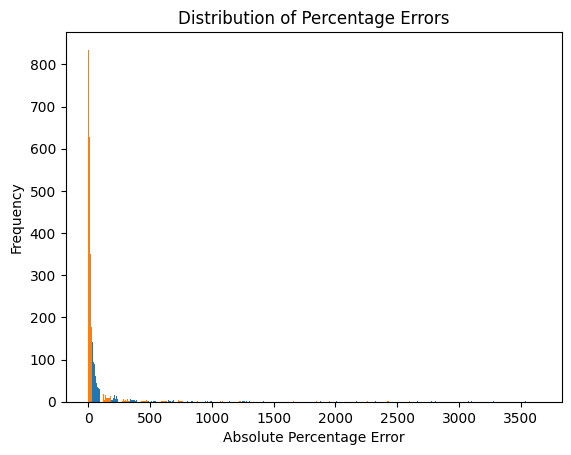

In [14]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins="auto")
    # zoom on the first 30% of the data
    # plt.xlim(0, 500)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.show()


# Use the function on your model and test set
# replace "your_model" with the variable of your model
evaluate_model(model, Signal_test, X_test_other, y_test)

Batchsize 32

In [15]:
del history
del model
model = create_model(
    input_shape_signal, input_shape_other, units, dropout_rate, initial_lr, num_layers
)

Epoch 1/100
1167/1167 [==============================] - 31s 25ms/step - loss: 0.1392 - mean_absolute_percentage_error: 136.9701 - val_loss: 0.0944 - val_mean_absolute_percentage_error: 118.8341
Epoch 2/100
1167/1167 [==============================] - 28s 24ms/step - loss: 0.0762 - mean_absolute_percentage_error: 137.7083 - val_loss: 0.0729 - val_mean_absolute_percentage_error: 134.7342
Epoch 3/100
1167/1167 [==============================] - 27s 23ms/step - loss: 0.0708 - mean_absolute_percentage_error: 132.4993 - val_loss: 0.0735 - val_mean_absolute_percentage_error: 130.8209
Epoch 4/100
1167/1167 [==============================] - 30s 25ms/step - loss: 0.0671 - mean_absolute_percentage_error: 126.5765 - val_loss: 0.1413 - val_mean_absolute_percentage_error: 200.0005
Epoch 5/100
1167/1167 [==============================] - 29s 25ms/step - loss: 0.0634 - mean_absolute_percentage_error: 120.1393 - val_loss: 0.0691 - val_mean_absolute_percentage_error: 103.0530
Epoch 6/100
1167/1167 [==

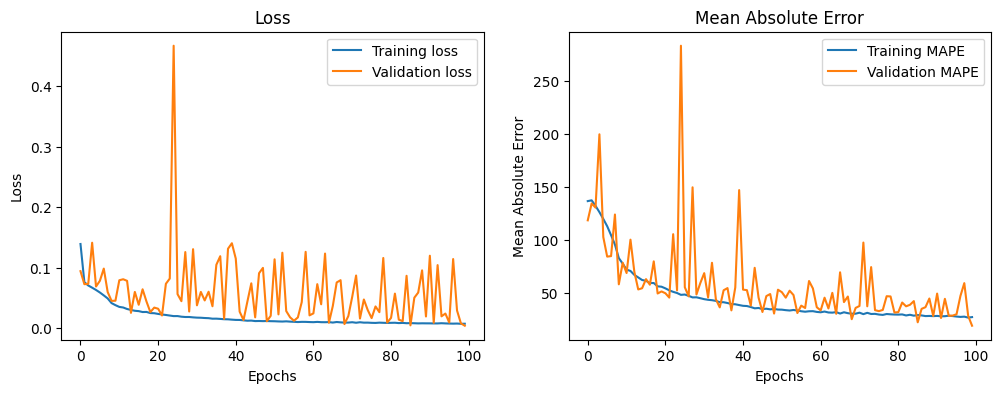

162/162 [==============================] - 1s 4ms/step - loss: 0.0041 - mean_absolute_percentage_error: 19.2048
Test Loss: 0.004077117890119553, Test Mean Absolute Error: 19.204814910888672
162/162 [==============================] - 1s 4ms/step


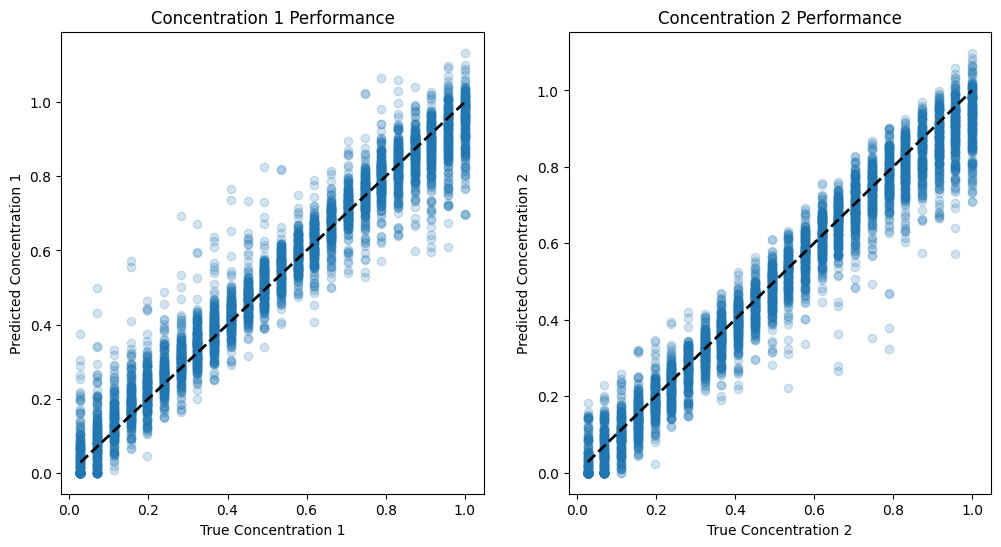

162/162 [==============================] - 1s 4ms/step - loss: 0.0041 - mean_absolute_percentage_error: 19.2048
Test Loss: 0.004077117890119553, Test Mean Absolute Error: 19.204814910888672
162/162 [==============================] - 1s 4ms/step


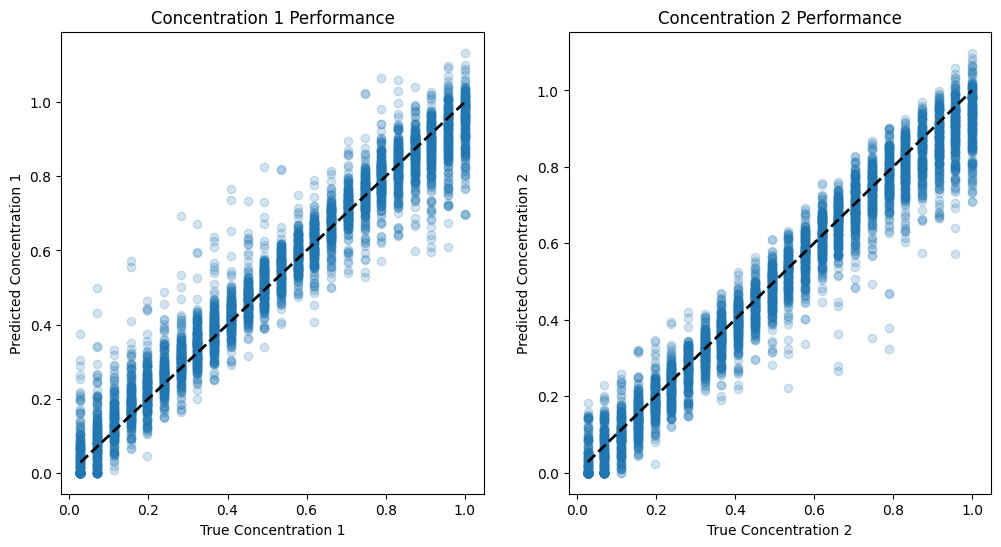

In [16]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 4ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 20.66873850087077%
Standard Deviation of Percentage Error on concentration 1: 53.50284451850198%
Mean Percentage Error on concentration 2: 17.740898053743688%
Standard Deviation of Percentage Error on concentration 2: 34.755466979838765%


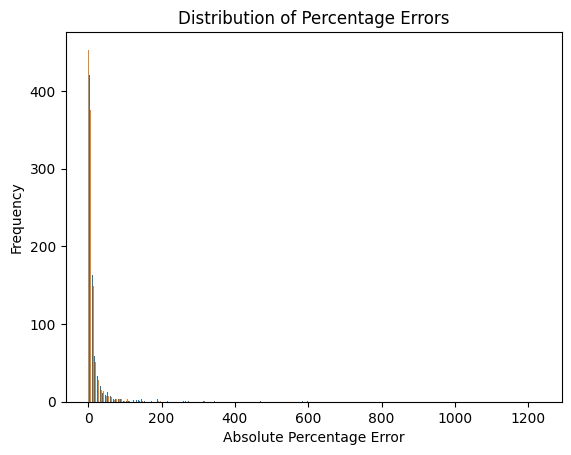

In [17]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins="auto")
    # zoom on the first 30% of the data
    # plt.xlim(0, 500)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.show()


# Use the function on your model and test set
# replace "your_model" with the variable of your model
evaluate_model(model, Signal_test, X_test_other, y_test)

Batchsize 64

In [18]:
del model
del history
model = create_model(
    input_shape_signal, input_shape_other, units, dropout_rate, initial_lr, num_layers
)

Epoch 1/100
584/584 [==============================] - 14s 22ms/step - loss: 0.1532 - mean_absolute_percentage_error: 135.6588 - val_loss: 0.1649 - val_mean_absolute_percentage_error: 126.7486
Epoch 2/100
584/584 [==============================] - 9s 15ms/step - loss: 0.0964 - mean_absolute_percentage_error: 126.6277 - val_loss: 0.0905 - val_mean_absolute_percentage_error: 112.6808
Epoch 3/100
584/584 [==============================] - 8s 14ms/step - loss: 0.0670 - mean_absolute_percentage_error: 122.7016 - val_loss: 0.0849 - val_mean_absolute_percentage_error: 102.6953
Epoch 4/100
584/584 [==============================] - 8s 14ms/step - loss: 0.0604 - mean_absolute_percentage_error: 114.0838 - val_loss: 0.0705 - val_mean_absolute_percentage_error: 131.9653
Epoch 5/100
584/584 [==============================] - 9s 15ms/step - loss: 0.0553 - mean_absolute_percentage_error: 105.6028 - val_loss: 0.0733 - val_mean_absolute_percentage_error: 100.3219
Epoch 6/100
584/584 [==================

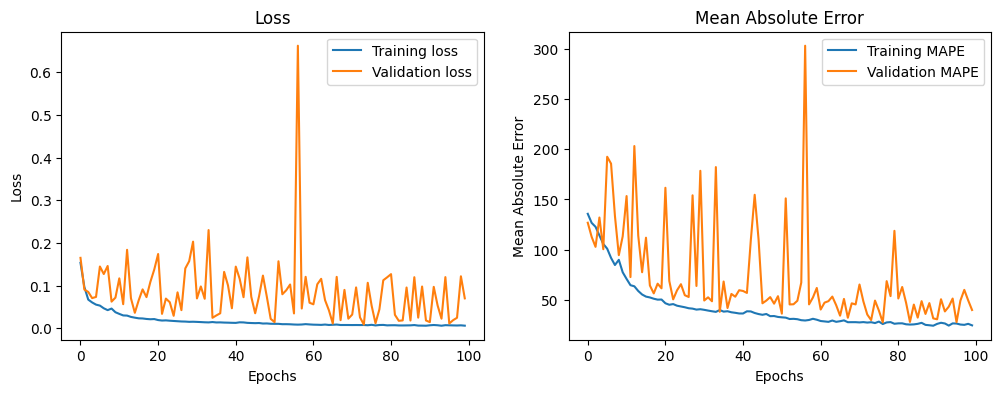

162/162 [==============================] - 1s 4ms/step - loss: 0.0679 - mean_absolute_percentage_error: 39.7469
Test Loss: 0.06793138384819031, Test Mean Absolute Error: 39.74688720703125
162/162 [==============================] - 64s 3ms/step


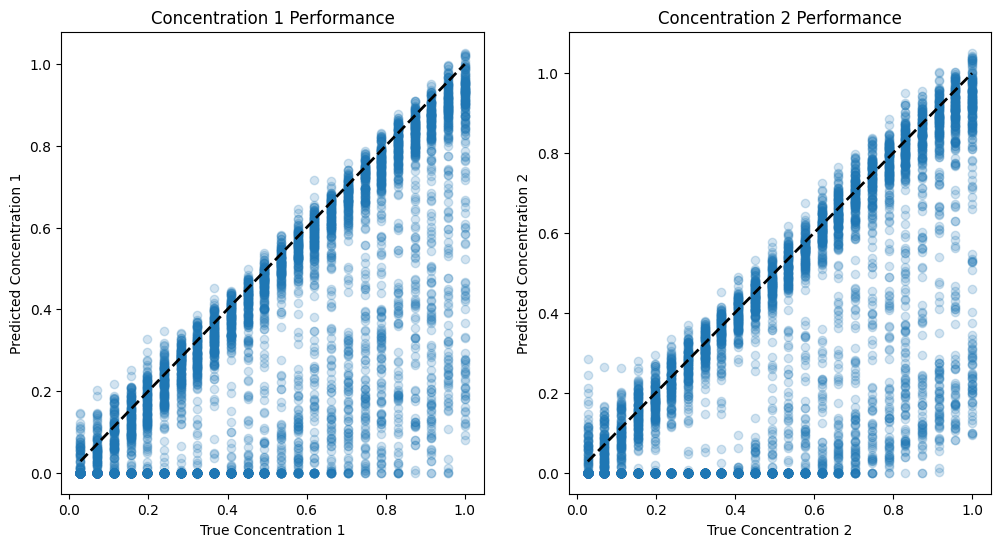

162/162 [==============================] - 1s 3ms/step - loss: 0.0679 - mean_absolute_percentage_error: 39.7469
Test Loss: 0.06793138384819031, Test Mean Absolute Error: 39.74688720703125
162/162 [==============================] - 1s 3ms/step


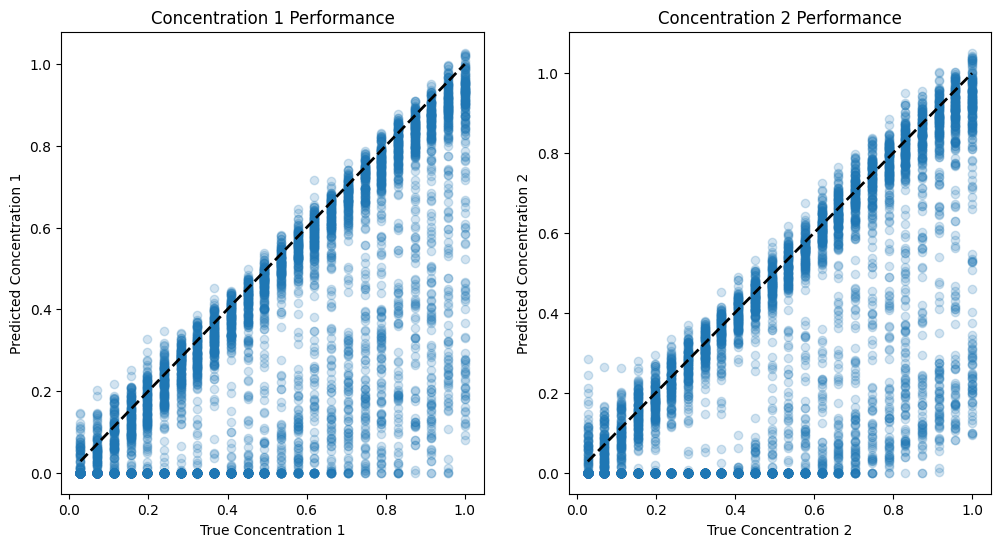

In [19]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

In [20]:
del model
del history
model = create_model(
    input_shape_signal, input_shape_other, units, dropout_rate, initial_lr, num_layers
)

Epoch 1/100
292/292 [==============================] - 13s 42ms/step - loss: 0.1434 - mean_absolute_percentage_error: 132.3181 - val_loss: 0.1618 - val_mean_absolute_percentage_error: 159.7480
Epoch 2/100
292/292 [==============================] - 7s 24ms/step - loss: 0.1013 - mean_absolute_percentage_error: 123.3844 - val_loss: 0.1590 - val_mean_absolute_percentage_error: 101.8918
Epoch 3/100
292/292 [==============================] - 8s 27ms/step - loss: 0.0854 - mean_absolute_percentage_error: 115.7418 - val_loss: 0.1374 - val_mean_absolute_percentage_error: 187.2446
Epoch 4/100
292/292 [==============================] - 7s 26ms/step - loss: 0.0774 - mean_absolute_percentage_error: 107.1613 - val_loss: 0.1250 - val_mean_absolute_percentage_error: 148.7455
Epoch 5/100
292/292 [==============================] - 8s 26ms/step - loss: 0.0684 - mean_absolute_percentage_error: 99.3634 - val_loss: 0.1030 - val_mean_absolute_percentage_error: 100.9543
Epoch 6/100
292/292 [===================

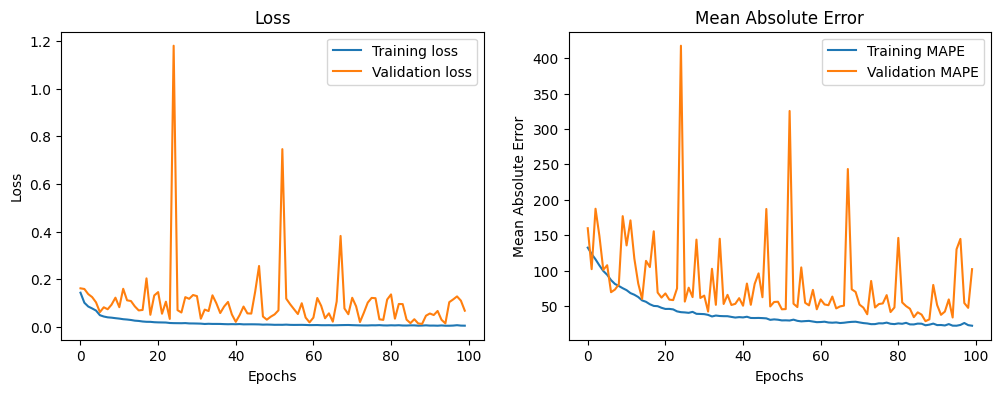

162/162 [==============================] - 1s 3ms/step - loss: 0.0695 - mean_absolute_percentage_error: 105.2941
Test Loss: 0.06952174752950668, Test Mean Absolute Error: 105.29405212402344
162/162 [==============================] - 1s 3ms/step


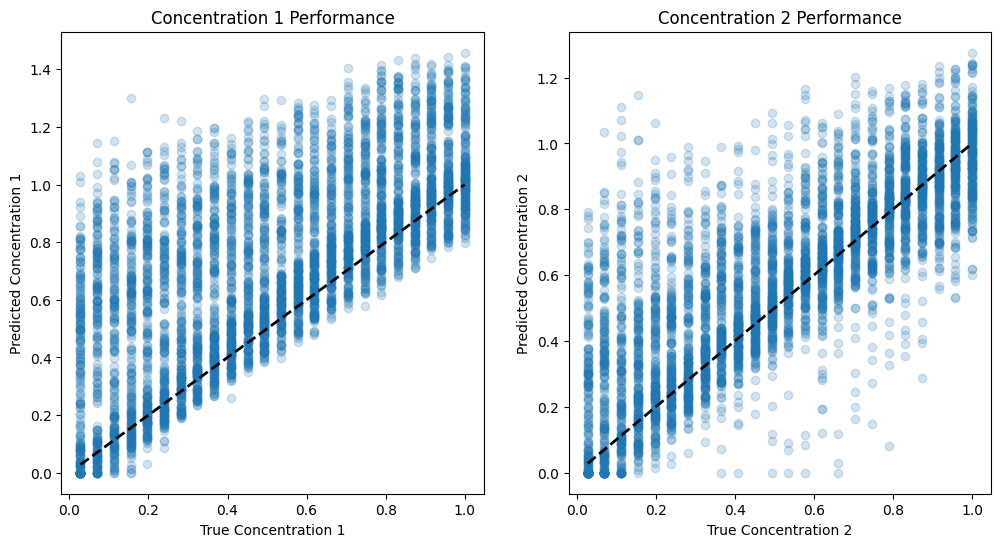

162/162 [==============================] - 1s 3ms/step - loss: 0.0695 - mean_absolute_percentage_error: 105.2941
Test Loss: 0.06952174752950668, Test Mean Absolute Error: 105.29405212402344
162/162 [==============================] - 1s 3ms/step


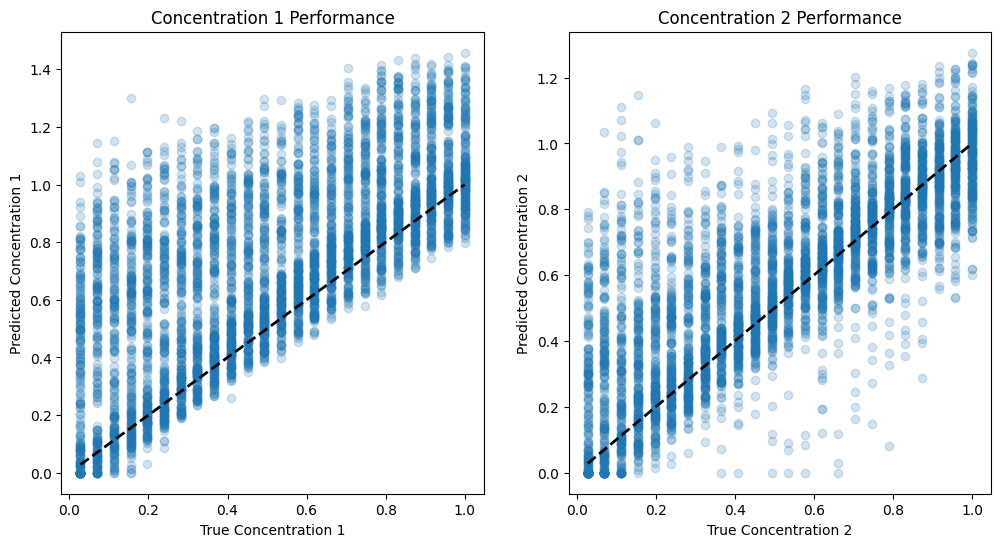

In [21]:
history = model.fit(
    [Signal_train, X_train_other],
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    # callbacks=[early_stopping, model_checkpoint],
)

# Plot the metrics
plot_metrics(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate([Signal_test, X_test_other], y_test)

print(f"Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}")

# Use the function to visualize the performance on the test set
plot_test_performance(model, Signal_test, X_test_other, y_test)

162/162 [==============================] - 1s 3ms/step
(5184, 2)
Mean Percentage Error on concentration 1: 130.54784512716913%
Standard Deviation of Percentage Error on concentration 1: 334.0109758776801%
Mean Percentage Error on concentration 2: 80.04032148198405%
Standard Deviation of Percentage Error on concentration 2: 231.08056714690554%


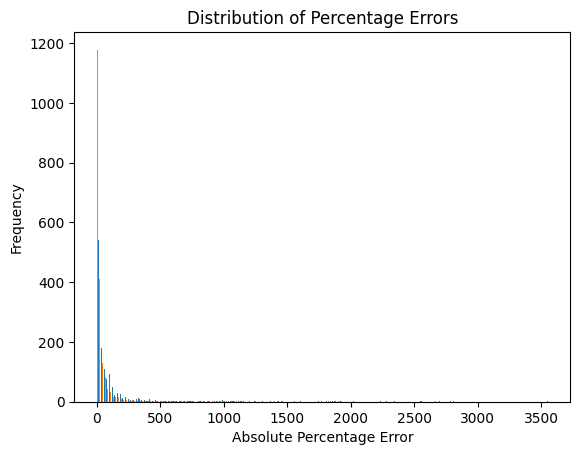

In [22]:
def evaluate_model(model, X_signal_test, X_other_test, y_test):
    # Ensure the model prediction and true values are in numpy array format
    y_test = np.array(y_test)

    # Get model predictions
    y_pred = model.predict([X_signal_test, X_other_test])

    # Calculate absolute percentage error
    errors = np.abs((y_pred - y_test) / y_test) * 100
    print(errors.shape)

    # Print mean and standard deviation of percentage error
    print(f"Mean Percentage Error on concentration 1: {np.mean(errors[:,0])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 1: {np.std(errors[:,0])}%"
    )
    print(f"Mean Percentage Error on concentration 2: {np.mean(errors[:,1])}%")
    print(
        f"Standard Deviation of Percentage Error on concentration 2: {np.std(errors[:,1])}%"
    )
    # print(f"Standard Deviation of Percentage Error: {np.std(errors)}%")

    # Plot histogram of errors
    plt.hist(errors, bins="auto")
    # zoom on the first 30% of the data
    # plt.xlim(0, 500)
    plt.xlabel("Absolute Percentage Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Percentage Errors")
    plt.show()


# Use the function on your model and test set
# replace "your_model" with the variable of your model
evaluate_model(model, Signal_test, X_test_other, y_test)